In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import normflows as nf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
import random
from torch.utils.data import DataLoader
import pandas as pd
import openturns as ot
print(f"Using device: {device}")
import pyvinecopulib as pv
from scipy.stats import gaussian_kde
from scipy.stats import gamma
from scipy.stats import expon
from scipy.stats import norm
from GPDFlow import DataTransform
from GPDFlow import T_mGPD_NF

/home/pgrad2/2448355h/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Using device: cuda


<pyvinecopulib.Bicop>
Bivariate copula: 
  family = Gumbel
  rotation = 0
  var_types = c,c
  parameters = 1.3

(5098, 2)


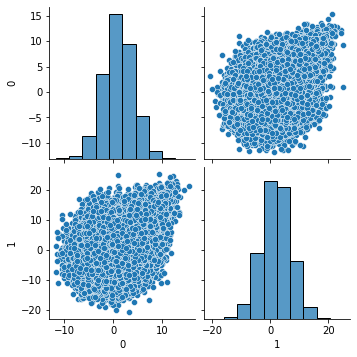

In [2]:
n_samples = 300000

seed = 1234
random.seed(seed)
np.random.seed(seed)

Gumble = pv.Bicop(pv.BicopFamily.gumbel, parameters=np.array([[1.3]]))

cop = Gumble
print(cop)

U = cop.simulate(n_samples, seeds = np.array([seed, seed+1]))

alpha = 2.0
beta  = 1.0  # scale




margin1 = norm.ppf(U[:,0], loc=1, scale=3)
# margin1 = gamma.ppf(U[:,0], loc=1, scale=3)
# margin2 = expon.ppf(U[:,1],  scale =5 )
margin2 = norm.ppf(U[:,1], loc=2, scale=5)

samples_origin = np.stack([margin1,margin2],axis=1)
sns.pairplot(pd.DataFrame(samples_origin),diag_kws={'bins': 10})

thres = np.quantile(samples_origin, 0.99,axis=0)

cond = (samples_origin[:,0] > thres[0] ) | (samples_origin[:,1] > thres[1] ) 
samples = samples_origin[cond,:]

thres = thres.reshape(1,-1)
samples = samples - thres
print(samples.shape)

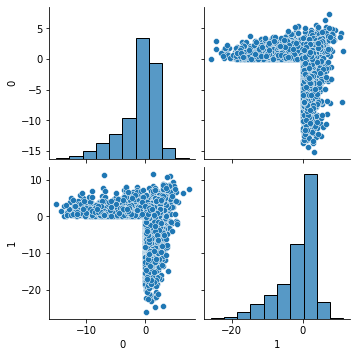

In [3]:
# Visualize the samples
sns.pairplot(pd.DataFrame(samples), diag_kws={'bins': 10})

In [4]:
data = torch.tensor(samples, dtype=torch.float, device = device)
print(data.shape)

torch.Size([5098, 2])


In [5]:
memory = torch.cuda.memory_allocated(device) /10**9
print('{:.2f}G GPU memory allocated'.format(memory))

0.00G GPU memory allocated


In [6]:
dim = 2

base = nf.distributions.DiagGaussian(dim)
# base = my_DiagGaussian(dim)


num_layers = 16
torch.manual_seed(0)

latent_size = dim
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(num_layers):
    s = nf.nets.MLP([latent_size, 10 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    t = nf.nets.MLP([latent_size, 10* latent_size, latent_size], init_zeros=True, output_fn='tanh')
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]


f_T_model = nf.NormalizingFlow(base, flows)
f_T_model = f_T_model.to(device)

# f_T_model.sample(num_samples=2 ** 7)
# z_np = z.to('cpu').data.numpy()
# plt.figure(figsize=(15, 15))
# plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (200, 200), range=[[-3, 3], [-3, 3]])
# plt.gca().set_aspect('equal', 'box')
# plt.show()

batch_size = 128
loss_history = []
epochs = 50

model = T_mGPD_NF(dim=dim, flow =f_T_model, device=device, s_min=-10,
                  s_max = 10, num_integration_points=1000, penalty_lambda=10000)


optimizer = torch.optim.Adam([
    {'params': model.flow_model.parameters(), 'lr': 1e-2},  # Flow layers
    {'params': model.data_transform.log_sigma, 'lr': 1e-1},  # Faster for log_sigma
    {'params': model.data_transform.theta, 'lr': 1e-1}       # Faster for gamma
], weight_decay = 1e-5 )
# for name, param in model.named_parameters():
#     print(name, param)



Epoch 1/50, Loss: 1.7701
Epoch 0 - Learning Rate: 0.01


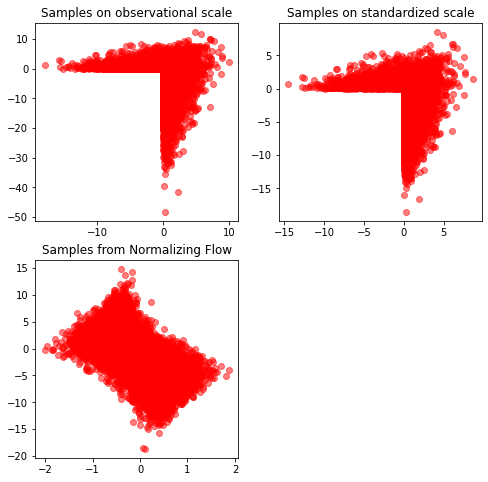

Epoch 2/50, Loss: 1.7474
Epoch 1 - Learning Rate: 0.009990133642141357
Epoch 3/50, Loss: 1.7421
Epoch 2 - Learning Rate: 0.009960573506572389
Epoch 4/50, Loss: 1.7396
Epoch 3 - Learning Rate: 0.009911436253643442
Epoch 5/50, Loss: 1.7424
Epoch 4 - Learning Rate: 0.009842915805643154
Epoch 6/50, Loss: 1.7376
Epoch 5 - Learning Rate: 0.009755282581475767
Epoch 7/50, Loss: 1.7347
Epoch 6 - Learning Rate: 0.009648882429441256
Epoch 8/50, Loss: 1.7363
Epoch 7 - Learning Rate: 0.009524135262330098
Epoch 9/50, Loss: 1.7373
Epoch 8 - Learning Rate: 0.009381533400219317
Epoch 10/50, Loss: 1.7348
Epoch 9 - Learning Rate: 0.009221639627510075
Epoch 11/50, Loss: 1.7439
Epoch 10 - Learning Rate: 0.009045084971874737


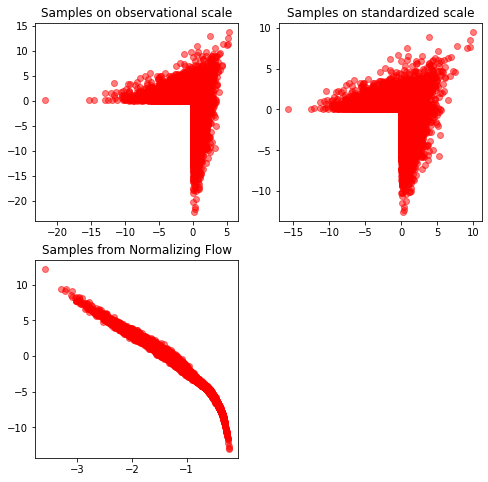

Epoch 12/50, Loss: 18.4874
Epoch 11 - Learning Rate: 0.008852566213878947
Epoch 13/50, Loss: 1.7361
Epoch 12 - Learning Rate: 0.008644843137107058
Epoch 14/50, Loss: 1.7359
Epoch 13 - Learning Rate: 0.008422735529643444
Epoch 15/50, Loss: 1.7360
Epoch 14 - Learning Rate: 0.00818711994874345
Epoch 16/50, Loss: 1.7326
Epoch 15 - Learning Rate: 0.007938926261462368
Epoch 17/50, Loss: 1.7323
Epoch 16 - Learning Rate: 0.007679133974894984
Epoch 18/50, Loss: 1.7363
Epoch 17 - Learning Rate: 0.007408768370508577
Epoch 19/50, Loss: 1.7327
Epoch 18 - Learning Rate: 0.0071288964578253644
Epoch 20/50, Loss: 1.7332
Epoch 19 - Learning Rate: 0.0068406227634233915
Epoch 21/50, Loss: 1.7329
Epoch 20 - Learning Rate: 0.006545084971874738


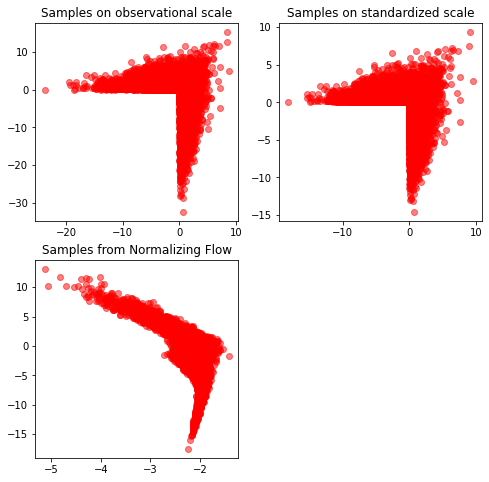

Epoch 22/50, Loss: 1.7335
Epoch 21 - Learning Rate: 0.006243449435824274
Epoch 23/50, Loss: 1.7330
Epoch 22 - Learning Rate: 0.005936906572928625
Epoch 24/50, Loss: 1.7322
Epoch 23 - Learning Rate: 0.005626666167821524
Epoch 25/50, Loss: 1.7360
Epoch 24 - Learning Rate: 0.005313952597646569
Epoch 26/50, Loss: 1.7370
Epoch 25 - Learning Rate: 0.005000000000000002
Epoch 27/50, Loss: 1.7356
Epoch 26 - Learning Rate: 0.004686047402353435
Epoch 28/50, Loss: 1.7312
Epoch 27 - Learning Rate: 0.004373333832178481
Epoch 29/50, Loss: 1.7307
Epoch 28 - Learning Rate: 0.0040630934270713785
Epoch 30/50, Loss: 1.7311
Epoch 29 - Learning Rate: 0.0037565505641757274
Epoch 31/50, Loss: 1.7306
Epoch 30 - Learning Rate: 0.0034549150281252662


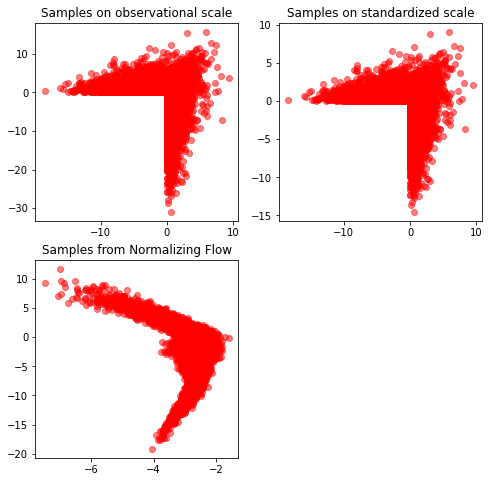

Epoch 32/50, Loss: 1.7294
Epoch 31 - Learning Rate: 0.0031593772365766134
Epoch 33/50, Loss: 1.7308
Epoch 32 - Learning Rate: 0.0028711035421746384
Epoch 34/50, Loss: 1.7297
Epoch 33 - Learning Rate: 0.002591231629491424
Epoch 35/50, Loss: 1.7302
Epoch 34 - Learning Rate: 0.0023208660251050166
Epoch 36/50, Loss: 1.7296
Epoch 35 - Learning Rate: 0.0020610737385376356
Epoch 37/50, Loss: 1.7300
Epoch 36 - Learning Rate: 0.001812880051256552
Epoch 38/50, Loss: 1.7290
Epoch 37 - Learning Rate: 0.001577264470356557
Epoch 39/50, Loss: 1.7296
Epoch 38 - Learning Rate: 0.0013551568628929439
Epoch 40/50, Loss: 1.7291
Epoch 39 - Learning Rate: 0.0011474337861210548
Epoch 41/50, Loss: 1.7285
Epoch 40 - Learning Rate: 0.0009549150281252636


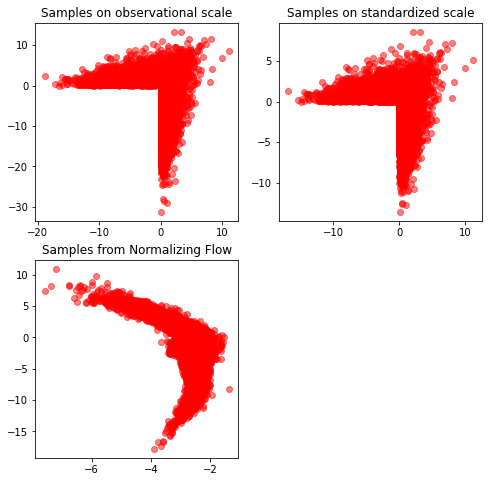

Epoch 42/50, Loss: 1.7291
Epoch 41 - Learning Rate: 0.000778360372489926
Epoch 43/50, Loss: 1.7281
Epoch 42 - Learning Rate: 0.0006184665997806823
Epoch 44/50, Loss: 1.7282
Epoch 43 - Learning Rate: 0.0004758647376699034
Epoch 45/50, Loss: 1.7281
Epoch 44 - Learning Rate: 0.0003511175705587434
Epoch 46/50, Loss: 1.7281
Epoch 45 - Learning Rate: 0.00024471741852423245
Epoch 47/50, Loss: 1.7279
Epoch 46 - Learning Rate: 0.00015708419435684522
Epoch 48/50, Loss: 1.7277
Epoch 47 - Learning Rate: 8.856374635655642e-05
Epoch 49/50, Loss: 1.7277
Epoch 48 - Learning Rate: 3.942649342761119e-05
Epoch 50/50, Loss: 1.7278
Epoch 49 - Learning Rate: 9.866357858642208e-06


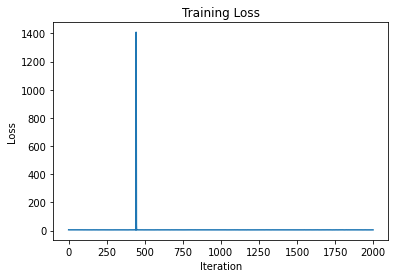

In [7]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=10, verbose=True
# )

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

Training_Data = DataLoader(data, batch_size=batch_size, shuffle=True)
torch.autograd.set_detect_anomaly(True)

for epoch in range(epochs):
    epoch_loss = 0.0
    
    for x_data in Training_Data:
        # Sample a batch of data from h_U

        batch_loss = model(x_data)

        # Backpropagation
        optimizer.zero_grad()
        batch_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)


        optimizer.step()

        # Record loss
        loss_history.append(batch_loss.item())
        epoch_loss += batch_loss.item()

        if torch.isnan(batch_loss) or torch.isinf(batch_loss):
            print("NaN or Inf detected!")
            break

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(x_data):.4f}")
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch} - Learning Rate: {current_lr}")
    # Debugging: Print shapes

    if epoch%10 == 0:
        samples_obs, samples_std, samples_T= model.sample(10000)
        plt.figure(figsize=(8,8))
        plt.subplot(2, 2, 1)
        plt.scatter(samples_obs[:,0].cpu().data.numpy(), samples_obs[:,1].cpu().data.numpy(), alpha=0.5, color='red')
        plt.title('Samples on observational scale')
        plt.subplot(2, 2, 2)
        plt.scatter(samples_std[:,0].cpu().data.numpy(), samples_std[:,1].cpu().data.numpy(), alpha=0.5, color='red')
        plt.title('Samples on standardized scale')
        plt.subplot(2, 2, 3)
        plt.scatter(samples_T[:,0].cpu().data.numpy(), samples_T[:,1].cpu().data.numpy(), alpha=0.5, color='red')
        plt.title('Samples from Normalizing Flow')
        plt.show()

    scheduler.step()
    
# Plot the training loss
plt.figure()
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [8]:
print(model.data_transform.get_sigma())
# print(model.data_transform.theta)
print(model.data_transform.get_gamma())

tensor([1.0461, 1.8053], device='cuda:0', grad_fn=<ClampBackward1>)
tensor([-0.0077, -0.0328], device='cuda:0', grad_fn=<MulBackward0>)


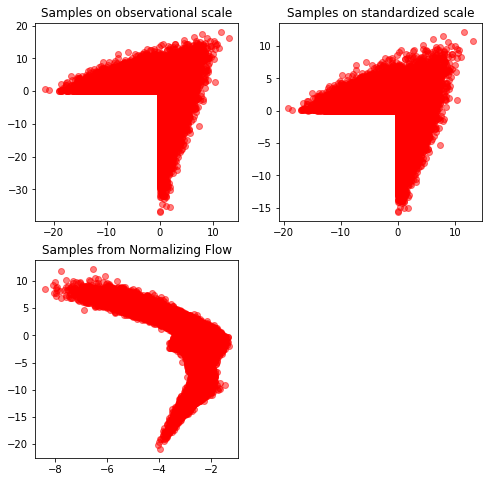

In [9]:
samples_obs, samples_std, samples_T= model.sample(n_samples)
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.scatter(samples_obs[:,0].cpu().data.numpy(), samples_obs[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples on observational scale')
plt.subplot(2, 2, 2)
plt.scatter(samples_std[:,0].cpu().data.numpy(), samples_std[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples on standardized scale')
plt.subplot(2, 2, 3)
plt.scatter(samples_T[:,0].cpu().data.numpy(), samples_T[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples from Normalizing Flow')
plt.show()

In [10]:
np.mean(abs(samples_T[:,0].cpu().data.numpy() - samples_T[:,1].cpu().data.numpy()))

np.float32(3.5719159)

In [11]:
def marginal_density_comparison(data, i, model, n_bootstrap):
    i
    margin = data[:,i]  # Example data
    # Step 1: Estimate the KDE of the data and get the KDE values
    kde = gaussian_kde(margin)
    tail_range = ( max(margin) - min(margin))/5
    x_values = np.linspace(min(margin) - tail_range, max(margin) + tail_range, 1000)
    kde_values = kde(x_values)
    
    # Step 2: Generate samples and compute their KDEs
    n_samples = len(margin)
    sample_kdes = []
    
    for _ in range(n_bootstrap):  # Step 3: Repeat 200 times
        samples_obs, samples_std, samples_T= model.sample(data.shape[0])
        sampled_data = samples_obs[:,i].cpu().data.numpy()
        sample_kde = gaussian_kde(sampled_data)
        sample_kde_values = sample_kde(x_values)
        sample_kdes.append(sample_kde_values)
    
    # Step 3: Calculate the 95% credible interval for the KDE of the samples
    sample_kdes = np.array(sample_kdes)
    mean = np.mean(sample_kdes, axis=0)
    lower_bound = np.percentile(sample_kdes, 2.5, axis=0)
    upper_bound = np.percentile(sample_kdes, 97.5, axis=0)
    
    # Step 4: Plot the KDE of the data and the credible intervals with Seaborn
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the KDE of the data
    sns.lineplot(x=x_values, y=kde_values, label='Empirical', color='darkorange', linewidth=2)
    
    # Plot the credible intervals
    sns.lineplot(x=x_values, y=mean, linestyle='dashdot', color='cornflowerblue', label='BootStrap Mean', linewidth=1.5)
    # sns.lineplot(x=x_values, y=lower_bound, linestyle='--', color='cornflowerblue', label='95% BootStrap CI', linewidth=1.5)
    # sns.lineplot(x=x_values, y=upper_bound, linestyle='--', color='cornflowerblue', linewidth=1.5)

    # Plot the credible interval as a ribbon
    ax.fill_between(x_values, lower_bound, upper_bound, color='cornflowerblue', alpha=0.3, label='95% Credible Interval')

    ax.set_title('Marignal Density of Dimension {}'.format(dim), fontsize=14)


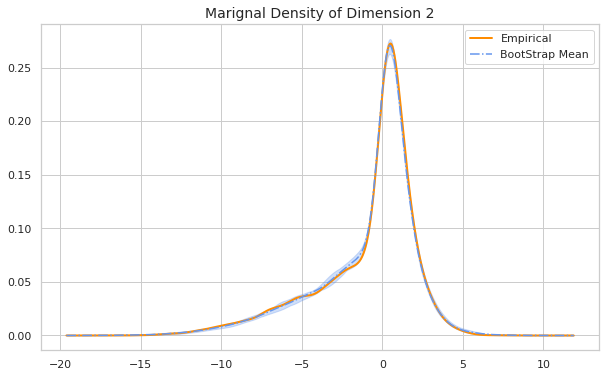

In [12]:
marginal_density_comparison(data= samples, i = 0, model=model, n_bootstrap = 20)

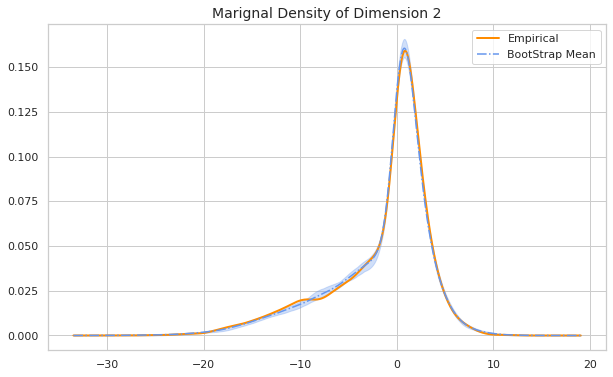

In [13]:
marginal_density_comparison(data= samples, i = 1, model=model,  n_bootstrap = 20)

In [14]:
def empirical_upper_tail_dependence(X, p):

    # Compute the quantiles
    quantile = np.quantile(X, p, axis = 0)
    
    # Count joint exceedances
    joint_exceedance = np.sum((X[:,0] > quantile[0]) & (X[:,1] > quantile[1]))
    exceedance_X1 = np.sum(X[:,0] > quantile[0])
    
    # Calculate lambda_u
    if exceedance_X1 == 0:  # Avoid division by zero
        return 0.0
    chi_u = joint_exceedance / exceedance_X1
    return chi_u

def plot_tail_dependence(data, i, j, model, n_bootstrap):
    probs = np.linspace(0.80, 0.99, 100)
    # Compute lambda_u for each quantile
    chi_emp = [empirical_upper_tail_dependence(data[:,[i,j]], p) for p in probs]
    

    # Step 2: Generate samples and compute their KDEs
    n_samples = data.shape[0]
    sample_chi = []
    
    for _ in range(n_bootstrap):  # Step 3: Repeat 200 times
        samples_obs, samples_std, samples_T= model.sample(samples.shape[0])
        sampled_data = samples_obs.cpu().data.numpy()
        sample_chi.append( [empirical_upper_tail_dependence(sampled_data[:,[i,j]], p) for p in probs])

    
    # Step 3: Calculate the 95% credible interval for the KDE of the samples
    sample_chi = np.array(sample_chi)
    lower_bound = np.percentile(sample_chi, 2.5, axis=0)
    upper_bound = np.percentile(sample_chi, 97.5, axis=0)
    mean = np.mean(sample_chi, axis=0)
    
    # Step 4: Plot the KDE of the data and the credible intervals with Seaborn
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the KDE of the data
    sns.lineplot(x=probs, y=chi_emp, label='Empirical', color='darkorange', linewidth=2)
    
    # Plot the credible intervals
    sns.lineplot(x=probs, y=mean, linestyle='dashdot', color='cornflowerblue', label='BootStrap Mean', linewidth=1.5)
    # sns.lineplot(x=probs, y=lower_bound, linestyle='--', color='cornflowerblue', label='95% BootStrap CI', linewidth=1.5)
    # sns.lineplot(x=probs, y=upper_bound, linestyle='--', color='cornflowerblue', linewidth=1.5)
    ax.fill_between(probs, lower_bound, upper_bound, color='cornflowerblue', alpha=0.3, label='95% Credible Interval')
    
    ax.set_title('Chi Between Dimension {} and {}'.format(i+1,j+1), fontsize=14)

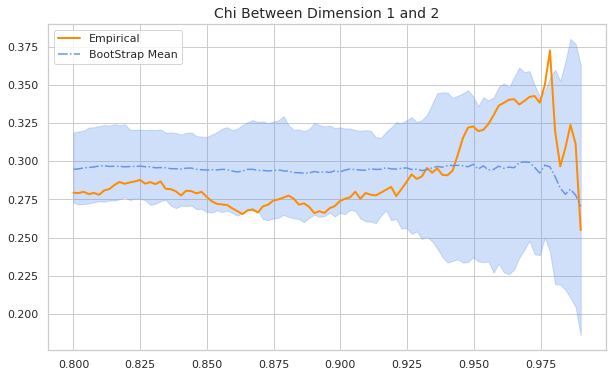

In [15]:
plot_tail_dependence(samples, i=0, j=1, model=model, n_bootstrap= 20)


In [16]:
n_bootstrap = 100
n_model_sample = 1000

probs = np.linspace(0.80, 0.996, 100)

Cuu = cop.cdf(np.stack([probs,probs],axis=1))
chi_theorical = (1 - 2*probs + Cuu)/(1-probs)

probs = np.linspace(0.80, 0.996, 100)
# Compute lambda_u for each quantile

# Step 2: Generate samples and compute their KDEs
sample_chi = []

for _ in range(n_bootstrap):  # Step 3: Repeat 200 times
    samples_obs, samples_std, samples_T= model.sample(n_model_sample)
    sampled_data = samples_obs.cpu().data.numpy()
    sample_chi.append( [empirical_upper_tail_dependence(sampled_data, p) for p in probs])


# Step 3: Calculate the 95% credible interval for the KDE of the samples
sample_chi = np.array(sample_chi)
lower_bound = np.percentile(sample_chi, 2.5, axis=0)
upper_bound = np.percentile(sample_chi, 97.5, axis=0)
mean = np.mean(sample_chi, axis=0)



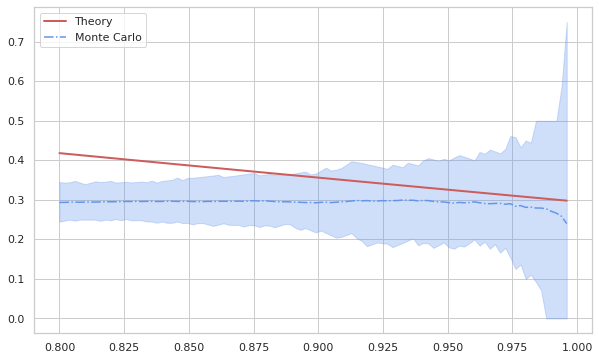

In [17]:
# Step 4: Plot the KDE of the data and the credible intervals with Seaborn
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the KDE of the data
sns.lineplot(x=probs, y=chi_theorical, label='Theory', color='indianred', linewidth=2)
# plt.hlines(y=chi_theorical, xmin=0.99, xmax=1, color='darkorange', linewidth=3)
# Plot the credible intervals
sns.lineplot(x=probs, y=mean, linestyle='dashdot', color='cornflowerblue', label='Monte Carlo', linewidth=1.5)
# sns.lineplot(x=probs, y=lower_bound, linestyle='--', color='cornflowerblue', label='95% BootStrap CI', linewidth=1.5)
# sns.lineplot(x=probs, y=upper_bound, linestyle='--', color='cornflowerblue', linewidth=1.5)
ax.fill_between(probs, lower_bound, upper_bound, color='cornflowerblue', alpha=0.3, label='95% Credible Interval')

In [18]:
def empirical_survival(X, u, sign):

    # Compute the quantiles
    n_obs = X.shape[0]
    n_dim = X.shape[1]
    cond = np.array([True]*n_obs)
    sign = list(sign)
    for j in range(n_dim):
        s = sign.pop(0)
        if s == '>':
            cond &= X[:,j] > u[j]
        else:
            cond &= X[:,j] < u[j]
    # Count joint exceedances
    joint_exceedance = np.sum(cond)

    return joint_exceedance/n_obs

def plot_survival_prob(data, u, sign, prob_exceed, model, n_bootstrap, n_model_sample):
    
    # Compute lambda_u for each quantile
    prob_emp = np.log(empirical_survival(data, u, sign))
    

    # Step 2: Generate samples and compute their KDEs
    n_samples = data.shape[0]
    sample_prob = []
    
    for _ in range(n_bootstrap):  # Step 3: Repeat 200 times
        samples_obs, samples_std, samples_T= model.sample(n_model_sample)
        sampled_data = samples_obs.cpu().data.numpy() + thres
        sample_prob.append( np.log(empirical_survival(sampled_data, u, sign))+ np.log(prob_exceed))

    
    # Step 3: Calculate the 95% credible interval for the KDE of the samples
    sample_prob = np.array(sample_prob)
    
    # Step 4: Plot the KDE of the data and the credible intervals with Seaborn
    sns.set(style="whitegrid")
    
    
    # Plot the KDE of the data
    ax = sns.boxplot(data=sample_prob, fill=False, color='cornflowerblue', label='BootStrap Prob')
    ax.axhline(prob_emp, color='darkorange', linewidth=2, label='Empirical')
    # ax.set_title('Chi Between Dimension {} and {}'.format(i+1,j+1), fontsize=14)

In [19]:
prob_exceed = (samples.shape[0])/samples_origin.shape[0]

In [20]:
prob_exceed

0.016993333333333333

In [21]:
thres

array([[ 8.00358884, 13.62510446]])

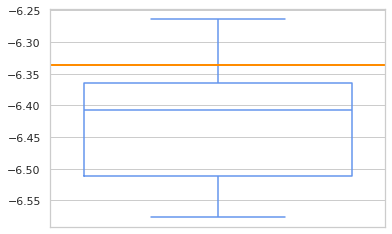

In [22]:
# plot_survival_prob(data= samples_origin, u = [6,15], sign="<>",prob_exceed=prob_exceed,  model= model, n_bootstrap=20,n_model_sample=samples.shape[0])
plot_survival_prob(data= samples_origin, u = [6,15], sign="<>",prob_exceed=prob_exceed,  model= model, n_bootstrap=20,n_model_sample=1000)

In [23]:
n_model_sample = samples.shape[0]
n_bootstrap = 100

u1 = np.arange(0.3,1,0.1)
u2 = np.array([0.999]*len(u1))
prob_non_exceed = cop.cdf(np.stack([u1,u2],axis=1))

prob_partial_exceed = {}
prob = np.log(u1 - prob_non_exceed)
for i in range(len(u1)):
    prob_partial_exceed[f'P(X1<q{u1[i]:.2f}, X2>q{u2[i]:.3f})'] = prob[i]


x1 = norm.ppf(u1, loc=1, scale=3)
# x2 = expon.ppf(u2,  scale =5 )
x2 = norm.ppf(u2, loc=2, scale=5)

prob_exceed_dict =   dict([(f'P(X1<q{u1[i]:.2f}, X2>q{u2[i]:.3f})', []) for i in range(len(x1))])
for _ in range(n_bootstrap):  # Step 3: Repeat 200 times
    samples_obs, samples_std, samples_T= model.sample(n_model_sample)
    samples_data = samples_obs.cpu().data.numpy() + thres
    
    for i in range(len(x1)):
        val = np.log(empirical_survival(samples_data, [x1[i],x2[0]], "<>"))+ np.log(prob_exceed)
        prob_exceed_dict[f'P(X1<q{u1[i]:.2f}, X2>q{u2[i]:.3f})'].append(val)

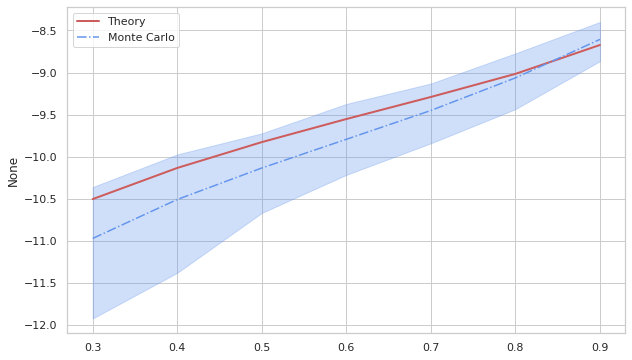

In [24]:
df = pd.DataFrame(prob_exceed_dict)
prob_partial_exceed_list = [value for key, value in prob_partial_exceed.items() ]

mean = np.mean(df,axis=0)
lower_bound = np.quantile(df, 0.025, axis=0)
upper_bound = np.quantile(df, 0.975, axis=0)
# Create the boxplot
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=u1, y=prob_partial_exceed_list, label='Theory', color='indianred', linewidth=2)

sns.lineplot(x=u1, y=mean, linestyle='dashdot', color='cornflowerblue', label='Monte Carlo', linewidth=1.5)

ax.fill_between(u1, lower_bound, upper_bound, color='cornflowerblue', alpha=0.3, label='95% Credible Interval')

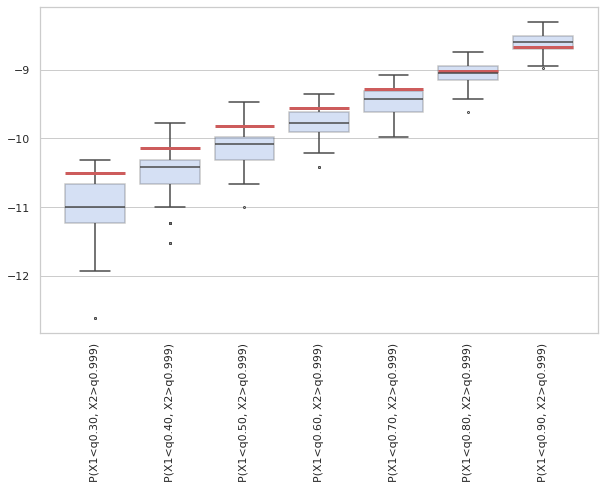

In [25]:
df = pd.DataFrame(prob_exceed_dict)

# Create the boxplot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, color="cornflowerblue", fliersize=2, linewidth=1.5, boxprops=dict(alpha=0.3))
plt.xticks(rotation=90)
for i, prob_index in enumerate(prob_partial_exceed):
    plt.hlines(y=prob_partial_exceed[prob_index], xmin=i - 0.4, xmax=i + 0.4, color='indianred', linewidth=3)

In [26]:
np.exp(-9)

np.float64(0.00012340980408667956)